In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='income_tax_collections',
    persist_directory='./income_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [68]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    rewrite_cnt: int
    context: List[Document]
    answer: str

In [57]:
def retrieve(state: AgentState) -> AgentState:
    """
    'retrieve' Node
    : 사용자의 질문에 기반하여, 벡터 스토어에서 관련 문서를 검색한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 검색된 문서가 추가된 state
    """
    
    query = state['query']
    context = retriever.invoke(query)
    
    return {'context': context}

In [8]:
from langsmith import Client

client = Client()

In [58]:
rag_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

def generate(state: AgentState) -> AgentState:
    """
    'generate' Node
    : 사용자의 질문과 검색된 문서를 기반으로 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    context = state['context']
    
    rag_chain = rag_prompt | llm
    ai_message = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': ai_message}

In [59]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 또는 단어 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(
    f"""
    사용자의 질문을 보고, 아래 사전을 참고해 질문을 변경해주세요.
    
    - 원본 질문의 의도와 맥락은 변경하지 않고, 사전에 정의된 정보만 변경해야합니다.
    - 제목, 설명 등 부가적인 요소들을 제외하고 변경한 질문만 반환해주세요.
    - 변경하지 않아도 된다고 판단되면 원본 질문을 그대로 반환해주세요.
    
    사전: {dictionary}
    질문: {{query}}
    """
)

def rewrite(state: AgentState) -> AgentState:
    """
    'rewrite' Node
    : 사용자의 질문을 사전을 참고하여 변경한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 변경된 질문을 포함하는 state
    """
    
    query = state['query']
    rewrite_cnt = state['rewrite_cnt']
    
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    ai_message = rewrite_chain.invoke({'query': query})
    
    return {'query': ai_message, 'rewrite_cnt': rewrite_cnt + 1}

In [ ]:
from typing import Literal

doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    : 주어진 state를 기반으로 문서의 관련성을 판단한다.

    Args:
        - state(AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state

    Returns:
        - Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite' 반환
    """
    
    query = state['query']
    context = state['context']
    
    if state['rewrite_cnt'] > 0:
        return 'generate'
    
    doc_relevance_chain = doc_relevance_prompt | llm
    ai_message = doc_relevance_chain.invoke({'question': query, 'documents': context})
    
    return 'generate' if ai_message['Score'] == 0 else 'rewrite'

In [65]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

# edges
graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [66]:
graph = graph_builder.compile()

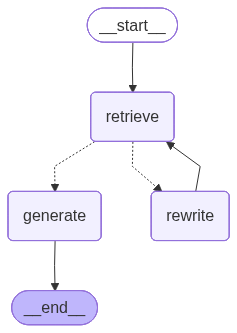

In [51]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
query = "연봉 5천만원인 직장인의 소득세는?"
initial_state = {'query': query, 'rewrite_cnt': 0}

graph.invoke(initial_state)

SCORE==1


{'query': '연봉 5천만원인 거주자의 소득세는?',
 'rewrite_cnt': 1,
 'context': [Document(id='f5c74d69-d34a-4bfe-80aa-e6ccbc22c35a', metadata={'source': '/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 